
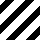
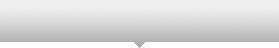
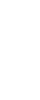
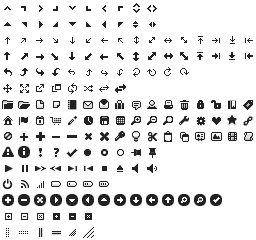
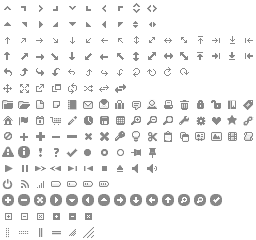
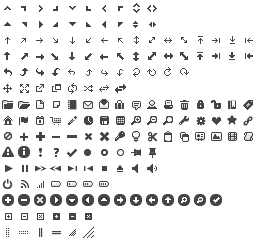
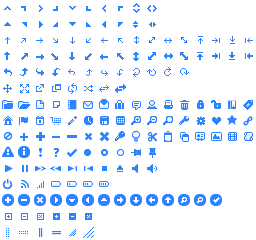
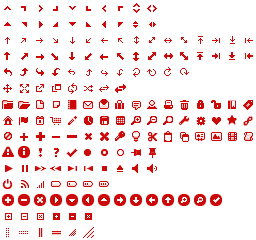
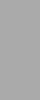
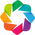
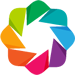
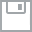
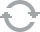
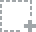
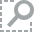
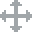
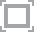
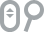

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline

from collections import OrderedDict

import json
import codecs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

import seaborn as sns

from bokeh.plotting import *
from bokeh.models import HoverTool, ColumnDataSource


sns.set(style="whitegrid")

In [2]:
table = pd.read_csv("data/wikipedia-geometry/final.csv", encoding="UTF-8")
table = table.set_index("pagename")

## computing simple graph

In [3]:
page_graph = nx.Graph()

editors = {}

def get_editors_set(page):
    editors = []
    revisions = json.load(codecs.open("data/wikipedia-geometry/revisions/%s.json" % (page), "r", "utf-8-sig"))
    
    revisions = pd.DataFrame(revisions)
    
    #print revisions.head()
    # editors = revisions[revisions["userid"] != 0]["user"].tolist()
    editors = revisions[revisions["userid"] != 0]["user"].tolist()
    
    return set(editors)

for p in table.index:
    title = p
    # page_graph.add_node(title)
    e = get_editors_set(title)
    editors[title] = e
#     print title
#     print len(e)

df = pd.DataFrame(columns=("u", "v", "coeditors"))

i = 0
for pu, u in editors.iteritems():
    for pv, v in editors.iteritems():
        intersection = u & v
        w = len(intersection)
        # print "(%s, %s, %s)" % (pu, pv, len(intersection))
        if (w > 0):
            page_graph.add_edge(pu, pv, coeditors=w)
            if (pu != pv):
                df.loc[i] = [ pu, pv, w ] 
            i += 1

In [4]:
nx.write_gexf(page_graph, "data/wikipedia-geometry/pages-linked-by-coeditors.gexf")

## network statistics

In [5]:
network_df = pd.DataFrame(index=table.index)

network_df.head()

""
pagename
2D computer graphics
3D computer graphics
3-sphere
Affine geometry
Algebraic geometry


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x107fb34d0>]], dtype=object)

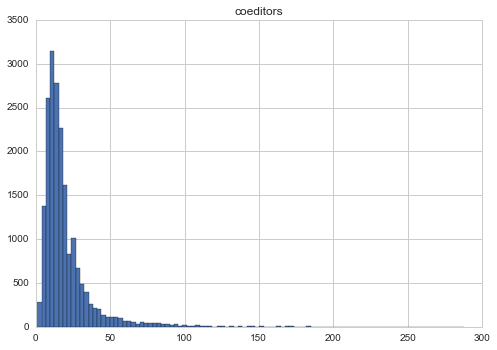

In [6]:
df.hist("coeditors", bins=100)

### centrality

In [7]:
centrality = nx.degree_centrality(page_graph)
closeness = nx.closeness_centrality(page_graph)
betweenness = nx.betweenness_centrality(page_graph, weight="coeditors")
current_flow_closeness = nx.current_flow_closeness_centrality(page_graph, weight="coeditors")
current_flow_betweenness = nx.current_flow_betweenness_centrality(page_graph, weight="coeditors")
#eigenvector = nx.eigenvector_centrality(page_graph)
eigenvector = nx.eigenvector_centrality_numpy(page_graph, weight="coeditors")

for index in network_df.index:
    network_df.ix[index,"centrality"] = centrality[index]
    network_df.ix[index,"closeness"] = closeness[index]
    network_df.ix[index,"betweenness"] = betweenness[index]
    network_df.ix[index,"current flow closeness"] = current_flow_closeness[index]
    network_df.ix[index,"current flow betweenness"] = current_flow_betweenness[index]
    network_df.ix[index,"eigenvector"] = eigenvector[index]

network_df.head()

,centrality,closeness,betweenness,current flow closeness,current flow betweenness,eigenvector
pagename,,,,,,
2D computer graphics,1.014388,1,0.015467,6.222645,0.009261,0.035027
3D computer graphics,1.014388,1,0.000000,8.099603,0.014511,0.058745
3-sphere,1.014388,1,0.000000,7.858913,0.010976,0.044655
Affine geometry,1.014388,1,0.000000,7.645164,0.009649,0.040396
Algebraic geometry,1.014388,1,0.000000,9.725693,0.017187,0.080923


In [8]:
network_df.to_csv("data/wikipedia-geometry/pages-linked-by-coeditors.stats.csv", encoding="UTF-8")

## adjacency (matplotlib)

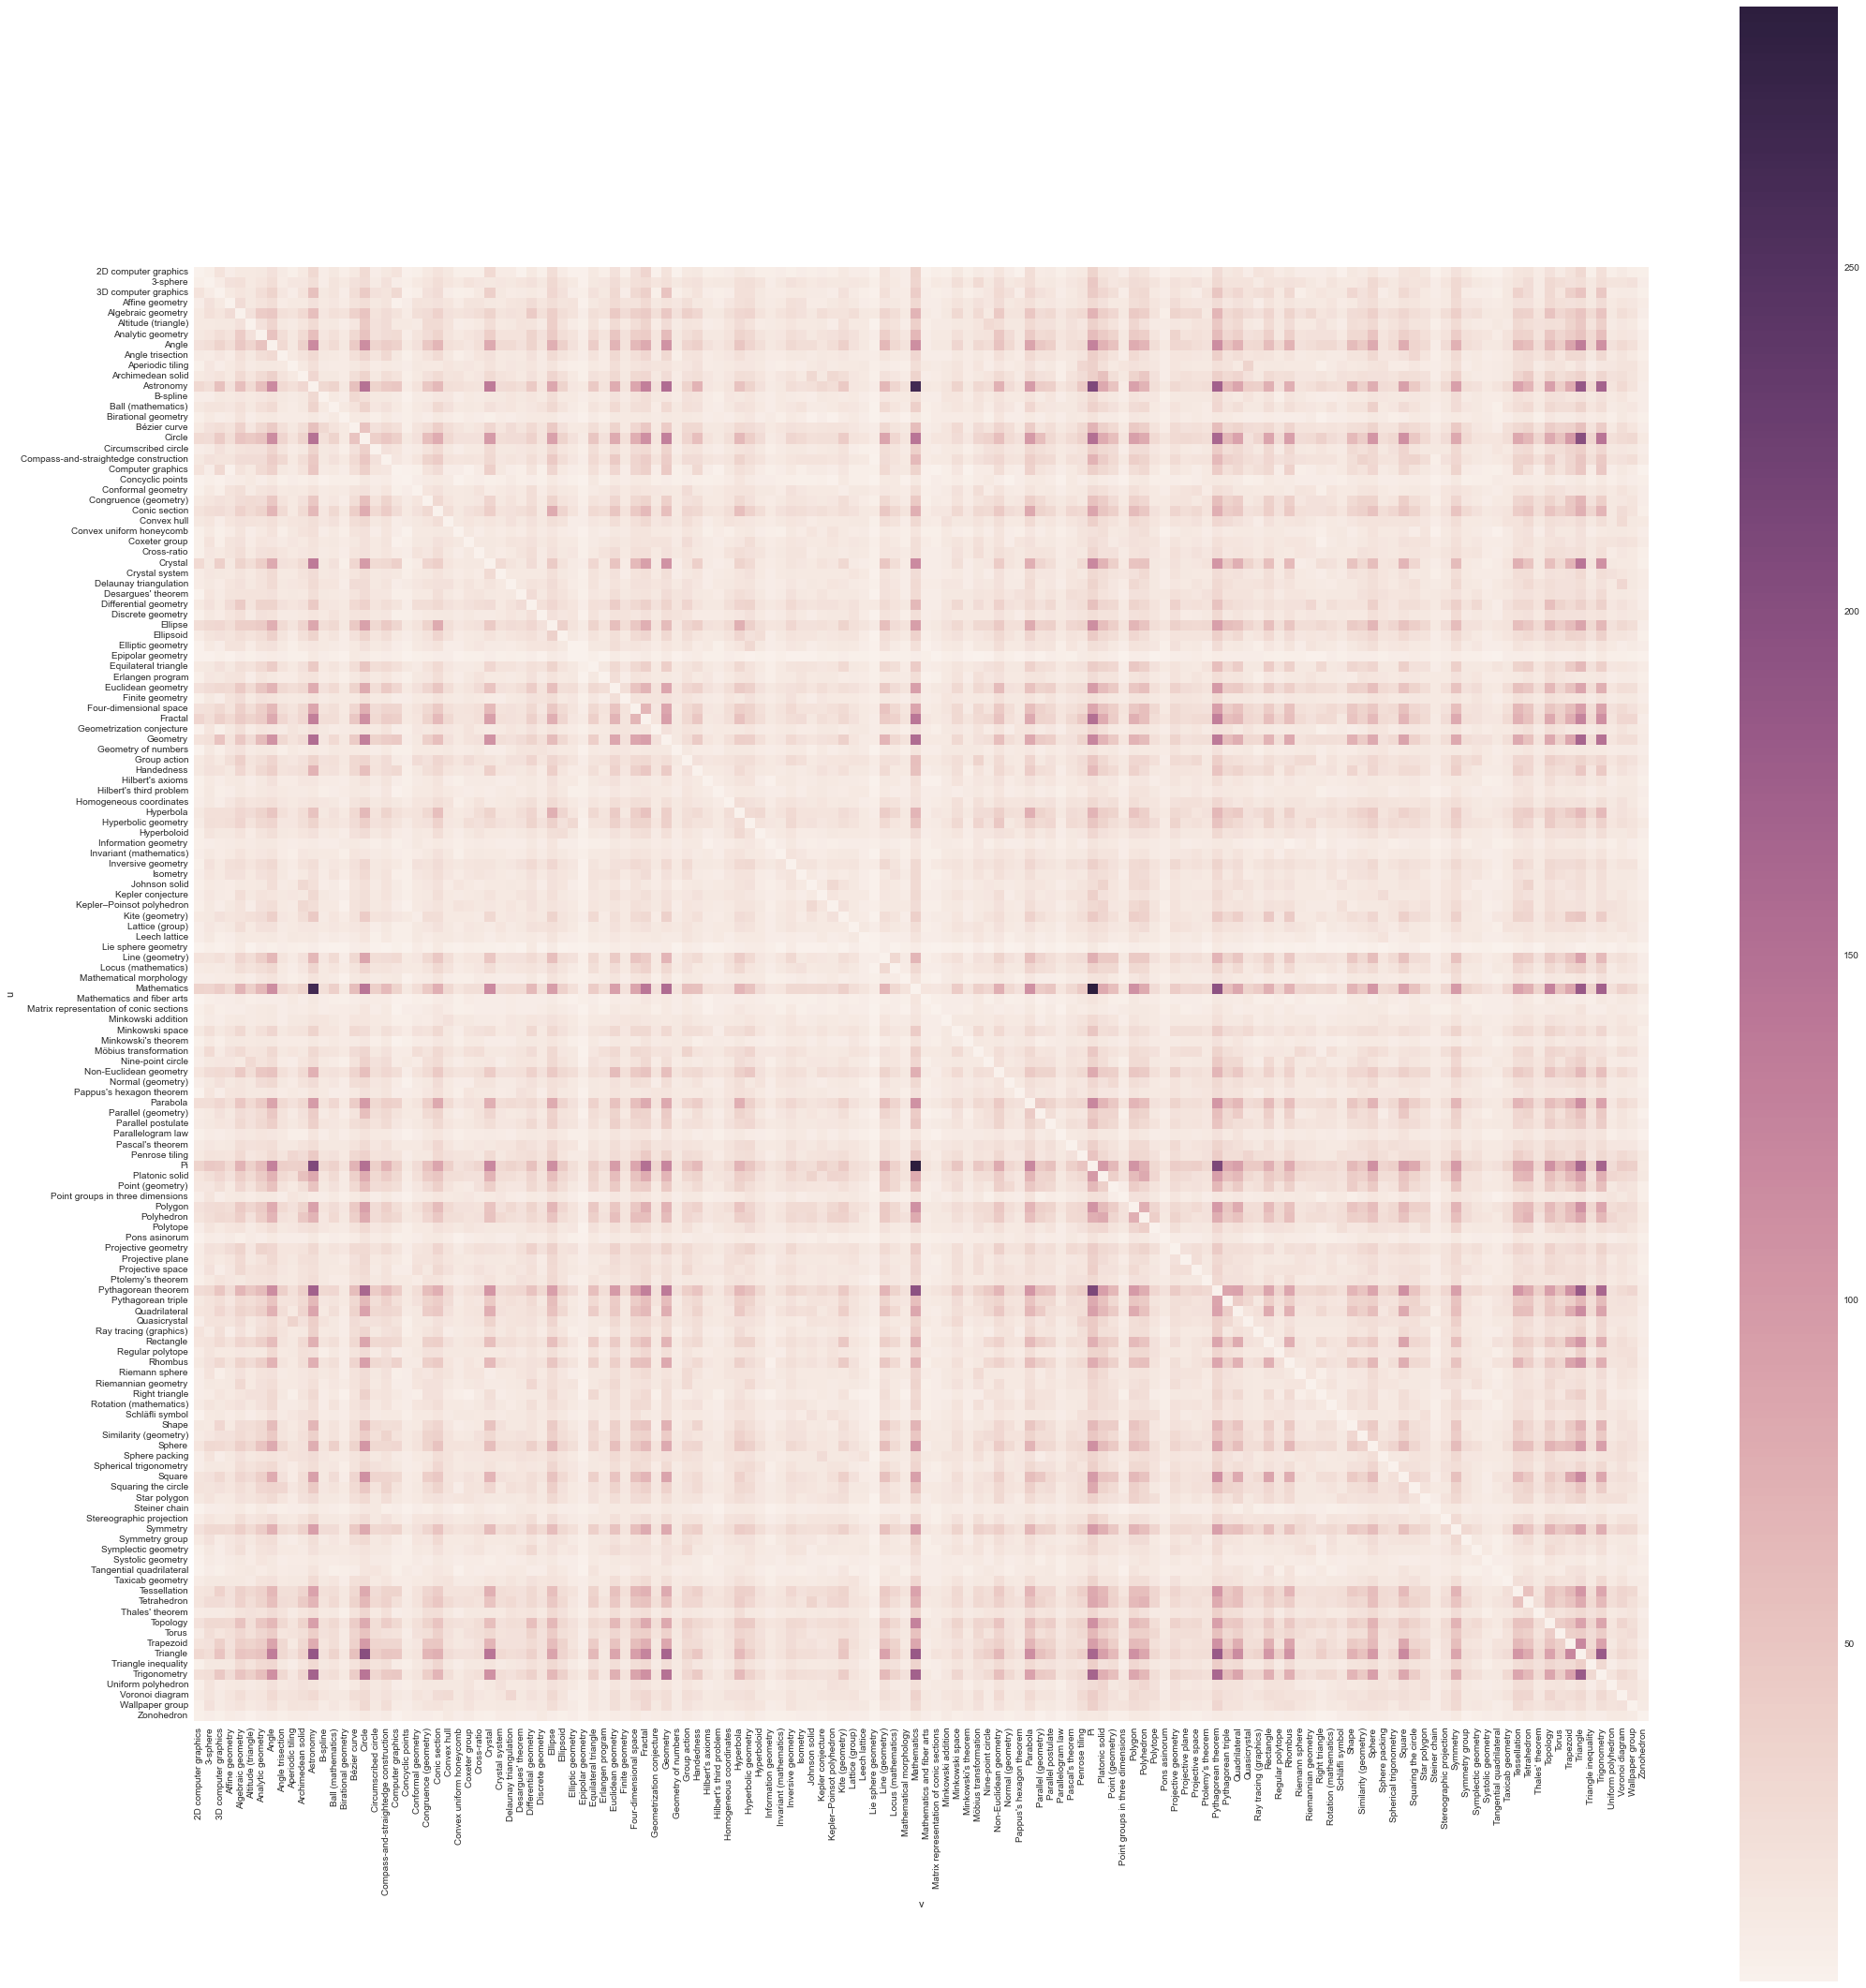

In [9]:
pv = df.pivot("u", "v", "coeditors")

f, ax = plt.subplots(figsize=(30,30))
sns.heatmap(pv, linewidths=0, square=True);
f.tight_layout()

## adjacency (bokeh)

In [10]:
c = list(nx.k_clique_communities(page_graph, 8))
# print len(c)
# print c

In [11]:
o = []
group = {}

print len(c)

for ci, clique in enumerate(c):
    o.extend(list(clique))
    
    for n in list(clique):
        group[n] = ci

print group    
    
# print o
# pv = df.pivot("u", "v", "coeditors")

# f, ax = plt.subplots(figsize=(30,30))
# sns.heatmap(pv, linewidths=0, square=True);
# f.tight_layout()


nodes = o
names = o #[node['name'] for node in sorted(data['nodes'], key=lambda x: x['group'])]

N = len(nodes)
counts = np.zeros((N, N))
for e in page_graph.edges(data=True):
    #print e
    p1 = o.index(e[0])
    p2 = o.index(e[1])

    counts[p1, p2] = e[2]["coeditors"]
    counts[p2, p1] = e[2]["coeditors"]

colormap = [
    "#444444", "#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99",
    "#e31a1c", "#fdbf6f", "#ff7f00", "#cab2d6", "#6a3d9a"
]

xname = []
yname = []
color = []
alpha = []
for i, n1 in enumerate(nodes):
    for j, n2 in enumerate(nodes):
        xname.append(n1)
        yname.append(n2)

        a = min(counts[i,j]/4.0, 0.9) + 0.1
        alpha.append(a)
#        color.append('lightgrey')

#         if n1['group'] == n2['group']:
#             color.append(colormap[n1['group']])
#         else:
#             color.append('lightgrey')


source = ColumnDataSource(
    data=dict(
        xname=xname,
        yname=yname,
        colors=color,
        alphas=alpha,
        count=counts.flatten(),
    )
)

output_file("page-coeditors.html")


p = figure(x_axis_location="above", tools="resize,hover,save", x_range=list(reversed(o)), y_range=o)
p.plot_width = 1200
p.plot_height = 2000

p.rect('xname', 'yname', 0.9, 0.9, source=source,
     color='colors', alpha='alphas', line_color=None)

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "5pt"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = np.pi/3

hover = p.select(dict(type=HoverTool))
hover.tooltips = OrderedDict([
    ('names', '@yname, @xname'),
    ('count', '@count'),
])

# show(p) # show the plot

1
{u'Systolic geometry': 0, u'Triangle inequality': 0, u'Matrix representation of conic sections': 0, u'Line (geometry)': 0, u'Zonohedron': 0, u'Elliptic geometry': 0, u'Homogeneous coordinates': 0, u'Geometrization conjecture': 0, u'2D computer graphics': 0, u'Spherical trigonometry': 0, u'Epipolar geometry': 0, u'B\xe9zier curve': 0, u'Kepler\u2013Poinsot polyhedron': 0, u'Fractal': 0, u'Polyhedron': 0, u'Altitude (triangle)': 0, u'Euclidean geometry': 0, u'Crystal': 0, u'Delaunay triangulation': 0, u'Trapezoid': 0, u'Lattice (group)': 0, u'Steiner chain': 0, u'Discrete geometry': 0, u'Pons asinorum': 0, u'Isometry': 0, u'Invariant (mathematics)': 0, u'Symmetry': 0, u'Congruence (geometry)': 0, u'Point (geometry)': 0, u'Squaring the circle': 0, u'Point groups in three dimensions': 0, u'Lie sphere geometry': 0, u'Voronoi diagram': 0, u'Equilateral triangle': 0, u'Hyperbola': 0, u'Rotation (mathematics)': 0, u'B-spline': 0, u'Parallelogram law': 0, u'Regular polytope': 0, u'Similarity 

# final report